
# Семинар 7 (part1): GradCam

В рамках данного семинара рассмотрим подробно модуль lightning.pytorch. Обучим классификационную сеть на датасете СARS196, который является бенчмарком для задачи metric-learning: https://paperswithcode.com/sota/metric-learning-on-cars196

Данные можно найти по ссылкам:
* meta : https://drive.google.com/file/d/1PD-lbbcKSelDeAYKafe3boc5mqqEe7X7/view?usp=sharing
* data : https://drive.google.com/file/d/1l9EnYMC-xGX706SY1kN8RceMmFViASfx/view?usp=sharing

А также рассмотрим библиотеку GradCam для интерпретации работы моделей компьютерного зрения:
repo - https://github.com/jacobgil/pytorch-grad-cam
paper - https://arxiv.org/abs/1610.02391

### Познакомимся с данными


In [1]:
!pip install typing_extensions==4.8.0
!pip install torch==2.4.1 torchvision
!pip install lightning pytorch-lightning timm faiss-cpu
!pip install opencv-python-headless
!pip install grad-cam
!pip install torch==2.2.2+cu118 torchvision==0.17.2+cu118 --index-url https://download.pytorch.org/whl/cu118

  Using cached torch-2.4.1-cp311-cp311-win_amd64.whl.metadata (27 kB)
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
  Using cached torchvision-0.24.0-cp311-cp311-win_amd64.whl.metadata (5.9 kB)
  Using cached torchvision-0.23.0-cp311-cp311-win_amd64.whl.metadata (6.1 kB)
  Using cached torchvision-0.22.1-cp311-cp311-win_amd64.whl.metadata (6.1 kB)
  Using cached torchvision-0.22.0-cp311-cp311-win_amd64.whl.metadata (6.3 kB)
  Using cached torchvision-0.21.0-cp311-cp311-win_amd64.whl.metadata (6.3 kB)
  Using cached torchvision-0.20.1-cp311-cp311-win_amd64.whl.metadata (6.2 kB)
  Using cached torchvision-0.20.0-cp311-cp311-win_amd64.whl.metadata (6.2 kB)
INFO: pip is still looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
  Using cached torchvision-0.19.1-cp311-cp311-win_amd64.whl.metadata (6.1 kB)
Usin

In [2]:
import torch, sys, subprocess
print("torch.__version__:", torch.__version__)
print("torch.version.cuda:", torch.version.cuda)
print("torch.cuda.is_available():", torch.cuda.is_available())
print("torch.cuda.device_count():", torch.cuda.device_count())
if torch.cuda.is_available():
    print("current_device:", torch.cuda.current_device())
    print("device name:", torch.cuda.get_device_name(0))
print("python executable:", sys.executable)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "g:\ml\2sem\NN_VK\venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "g:\ml\2sem\NN_VK\venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "g:\ml\2sem\NN_VK\venv\Lib\site-packages\ipykernel\kernelapp.py", line 758, in start
    self.io_loop.start()
  File "g:\ml\2sem\NN_VK\venv\Lib\site-packages\tornado

torch.__version__: 2.2.2+cu118
torch.version.cuda: 11.8
torch.cuda.is_available(): True
torch.cuda.device_count(): 1
current_device: 0
device name: NVIDIA GeForce GTX 1050 Ti
python executable: g:\ml\2sem\NN_VK\venv\Scripts\python.exe


In [3]:
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import torch
# device used for .to(device) calls
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# trainer accelerator expects 'gpu' or 'cpu'
trainer_accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'
print(f"Using device={device}, trainer_accelerator={trainer_accelerator}")

Using device=cuda, trainer_accelerator=gpu


In [4]:
import scipy.io
mat = scipy.io.loadmat('./devkit/cars_train_annos.mat')
fname_to_class = {fname:cl-1 for fname, cl in zip([i[0] for i in mat['annotations'][0]['fname']], 
                                                [i[0][0] for i in mat['annotations'][0]['class']])}
cars_meta = scipy.io.loadmat('./devkit/cars_meta.mat')
id_to_car = {idx: car[0] for idx, car in enumerate(cars_meta['class_names'][0])}

In [5]:
ADD_PATH = './cars_train/cars_train'

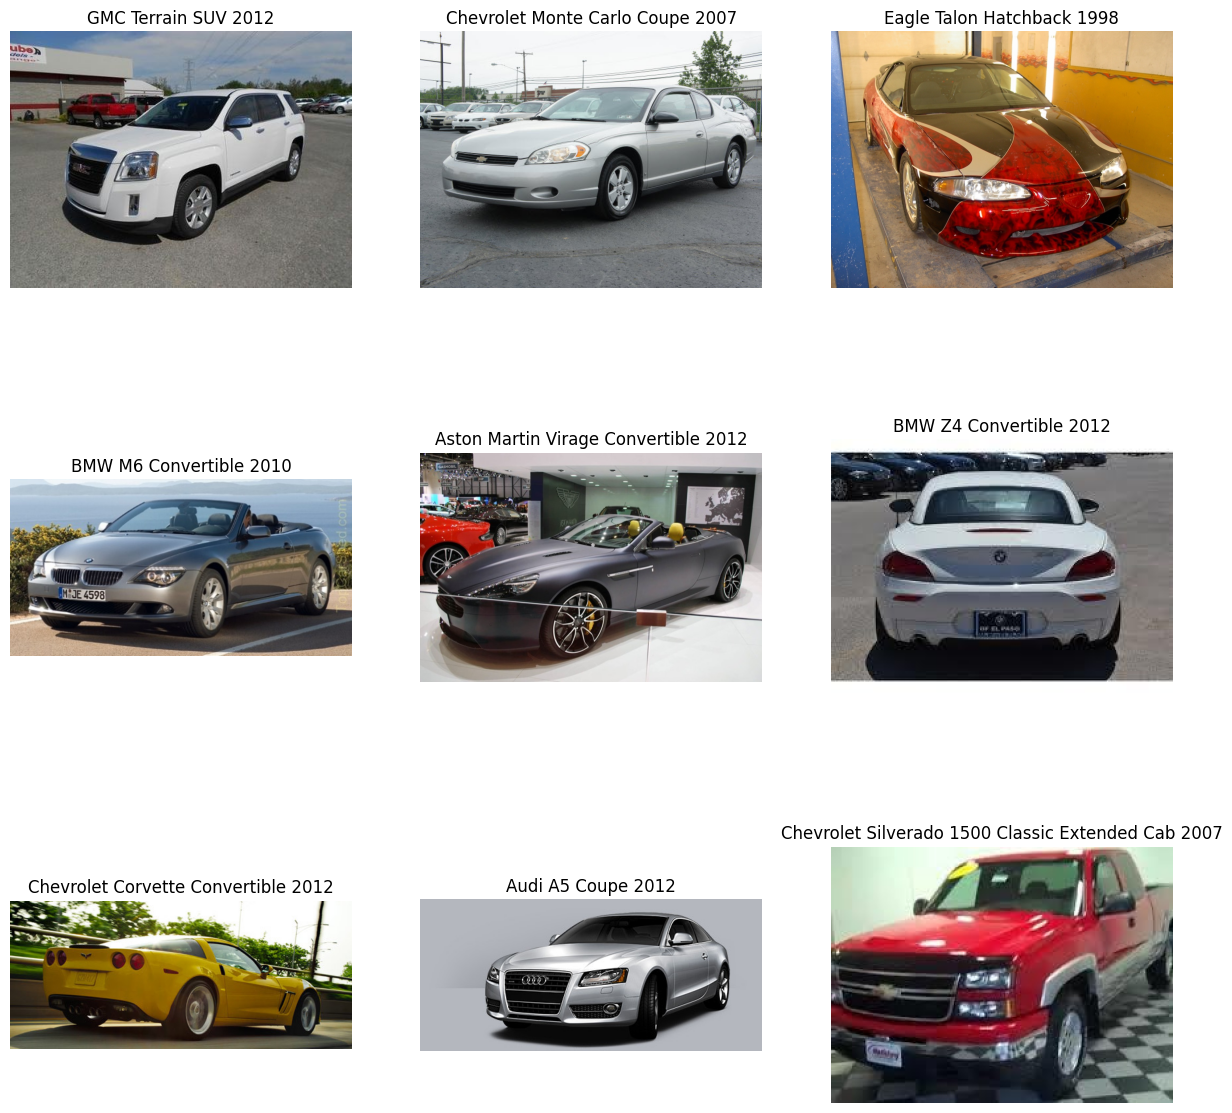

In [6]:
num_imgs = 9
cols = 3
rows = num_imgs // cols
fig, ax = plt.subplots(rows, cols, figsize = (15, 15))
for idx, im_idx in enumerate(random.sample([i for i in range(len(fname_to_class))], num_imgs)):
    filename, cl_id = list(fname_to_class.items())[im_idx]
    temp_image = cv2.imread(os.path.join(ADD_PATH, filename))
    temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
    ax[idx//cols][idx%cols].imshow(temp_image)
    ax[idx//cols][idx%cols].set_title(f'{id_to_car[cl_id]}')
    ax[idx//cols][idx%cols].axis('off')

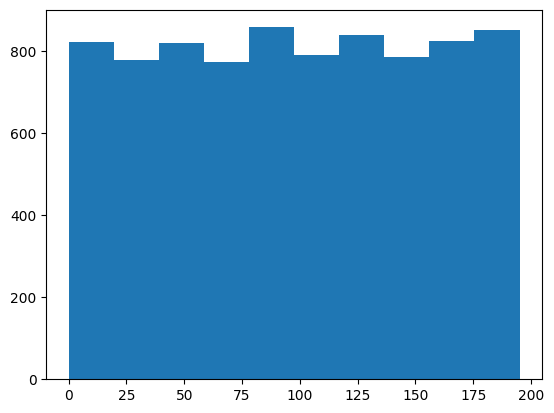

In [7]:
plt.hist(fname_to_class.values())
plt.show()

### Реализуем обертку для данных

In [8]:
import torch
import torchvision
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms

# Use torchvision transforms to avoid albumentations/pydantic dependency issues
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

val_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

class CropClassifDataset(torch.utils.data.Dataset):
    def __init__(self, cars_items, transforms):
        self.cars = cars_items
        self.transforms = transforms
        
    def __len__(self):
        return len(self.cars)

    def __getitem__(self, idx):
        filename, cl_id = self.cars[idx]
        image = cv2.imread(os.path.join(ADD_PATH, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transforms:
            image = self.transforms(image)
        sample = {'image': image, 'label': cl_id, 'fname': filename}
        return sample

In [9]:
items = list(fname_to_class.items())
random.shuffle(items)
train_items = items[:int(len(items) * 0.8)]
val_items = items[int(len(items) * 0.8):]

train_dataset = CropClassifDataset(train_items, train_transforms)
val_dataset = CropClassifDataset(val_items, val_transforms)


In [10]:
# Create a sampler that ensures multiple examples per class in a batch for triplet mining
from collections import defaultdict
def make_batch_sampler(items, batch_size, num_pos=4):
    # items: list of (fname, class)
    cls_to_idxs = defaultdict(list)
    for idx, (_, cl) in enumerate(items):
        cls_to_idxs[cl].append(idx)
    unique_classes = list(cls_to_idxs.keys())
    # we'll sample classes and then sample num_pos examples per class
    def generator():
        while True:
            batch = []
            classes = random.sample(unique_classes, batch_size // num_pos)
            for c in classes:
                chosen = random.choices(cls_to_idxs[c], k=num_pos)
                batch.extend(chosen)
            yield batch
    return generator()

batch_size = 64
num_pos = 4
# Note: simple custom generator used in a looping manner in DataLoader is not directly compatible;
# use shuffle=False and a custom collate that picks indices from the generator is a bit involved in notebook;
# For simplicity, use shuffle=True and rely on reasonably frequent class repeats (or implement custom sampler later).
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

### Обучим модель

In [11]:
from timm import create_model
from timm.scheduler import TanhLRScheduler
import lightning.pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor
import faiss

# Metrics implementations
import numpy as np

def precision_at_k(relevant, retrieved, k):
    retrieved_k = retrieved[:k]
    return len([r for r in retrieved_k if r in relevant]) / k


def recall_at_k(relevant, retrieved, k):
    retrieved_k = retrieved[:k]
    if len(relevant) == 0:
        return 0.0
    return len([r for r in retrieved_k if r in relevant]) / len(relevant)


def average_precision(relevant, retrieved):
    hits = 0
    sum_prec = 0.0
    for i, r in enumerate(retrieved, start=1):
        if r in relevant:
            hits += 1
            sum_prec += hits / i
    if hits == 0:
        return 0.0
    return sum_prec / hits


class EmbeddingNet(pl.LightningModule):
    def __init__(self, emb_size=512, lr=1e-4):
        super().__init__()
        self.save_hyperparameters()
        # Use EfficientNet-B0 backbone from timm
        self.backbone = create_model('efficientnet_b0', pretrained=True, num_classes=0, global_pool='avg')
        feat_dim = getattr(self.backbone, 'num_features', None)
        if feat_dim is None:
            # infer by dummy forward on CPU
            self.backbone.eval()
            with torch.no_grad():
                dummy = torch.zeros(1, 3, 224, 224)
                out = self.backbone(dummy)
            feat_dim = out.shape[1]
        self.embed = torch.nn.Linear(int(feat_dim), emb_size)
        self.lr = lr
        self.margin = 0.3
        # storage for validation embeddings/labels
        self._val_embeddings = []
        self._val_labels = []

    def forward(self, x):
        feats = self.backbone(x)
        emb = self.embed(feats)
        emb = torch.nn.functional.normalize(emb, p=2, dim=1)
        return emb

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=self.lr)
        return opt

    def training_step(self, batch, batch_idx):
        images = batch['image']
        labels = batch['label']
        embeddings = self(images)
        loss = batch_hard_triplet_loss(embeddings, labels, margin=self.margin)
        self.log('train_triplet_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def on_validation_epoch_start(self):
        # clear buffers
        self._val_embeddings = []
        self._val_labels = []

    def validation_step(self, batch, batch_idx):
        images = batch['image']
        labels = batch['label']
        embeddings = self(images)
        # accumulate on CPU
        self._val_embeddings.append(embeddings.detach().cpu())
        self._val_labels.append(labels.detach().cpu())
        return None

    def on_validation_epoch_end(self):
        # stack and compute retrieval metrics with faiss
        if len(self._val_embeddings) == 0:
            return
        embs = torch.cat(self._val_embeddings, dim=0).numpy().astype('float32')
        labels = torch.cat(self._val_labels, dim=0).numpy()
        index = faiss.IndexFlatL2(embs.shape[1])
        index.add(embs)
        k = 5
        D, I = index.search(embs, k+1)
        precisions = []
        recalls = []
        aps = []
        for i in range(embs.shape[0]):
            retrieved = [int(idx) for idx in I[i] if idx != i][:k]
            relevant = set(np.where(labels == labels[i])[0].tolist()) - {i}
            precisions.append(precision_at_k(relevant, retrieved, k))
            recalls.append(recall_at_k(relevant, retrieved, k))
            aps.append(average_precision(relevant, retrieved))
        self.log('val_precision@k', float(np.mean(precisions)), prog_bar=True)
        self.log('val_recall@k', float(np.mean(recalls)), prog_bar=True)
        self.log('val_map', float(np.mean(aps)), prog_bar=True)


def pairwise_distance(embeddings):
    dot = torch.matmul(embeddings, embeddings.t())
    sq_norm = torch.diag(dot)
    dist = sq_norm.unsqueeze(1) - 2.0 * dot + sq_norm.unsqueeze(0)
    dist = torch.clamp(dist, min=0.0)
    return dist


def batch_hard_triplet_loss(embeddings, labels, margin=0.3):
    dist = pairwise_distance(embeddings)
    labels = labels.unsqueeze(1)
    mask_pos = (labels == labels.t())
    # hardest positive: max over positives
    pos_dist = dist.clone()
    pos_dist[~mask_pos] = -1e12
    hardest_pos = pos_dist.max(dim=1)[0]
    # hardest negative: min over negatives
    max_dist = dist.max().item() if dist.numel() > 0 else 0.0
    dist_neg = dist + max_dist * mask_pos.float()
    hardest_neg = dist_neg.min(dim=1)[0]
    loss = torch.relu(hardest_pos - hardest_neg + margin).mean()
    return loss

g:\ml\2sem\NN_VK\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
# model
pl_model = EmbeddingNet(emb_size=512, lr=3e-4)
checkpoint_callback = ModelCheckpoint(monitor='val_map', mode='max', save_top_k=3)
# last_checkpoint = ModelCheckpoint(mode='max', monitor='time_log', save_top_k=1)

early_stopping = EarlyStopping(monitor="val_map", mode="max", patience=3)
lr_monitor = LearningRateMonitor(logging_interval='step')

# train model: choose accelerator based on availability
available_devices = torch.cuda.device_count() if torch.cuda.is_available() else 1
trainer = pl.Trainer(max_epochs=8, accelerator=trainer_accelerator, devices=available_devices, callbacks=[checkpoint_callback, early_stopping, lr_monitor])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
g:\ml\2sem\NN_VK\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [ ]:
import time
# Создаём временный Trainer только для одной эпохи
tmp_trainer = pl.Trainer(max_epochs=1, accelerator=trainer_accelerator, devices=available_devices, callbacks=[checkpoint_callback, early_stopping, lr_monitor])
start = time.time()
tmp_trainer.fit(model=pl_model, train_dataloaders=train_loader, val_dataloaders=valid_loader)
end = time.time()
epoch_time = end - start
print(f"Время одной эпохи: {epoch_time:.2f} сек")
print(f"Оценка времени обучения на {trainer.max_epochs} эпох: {epoch_time * trainer.max_epochs / 60:.1f} мин")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name     | Type         | Params | Mode 
--------------------------------------------------
0 | backbone | EfficientNet | 4.0 M  | train
1 | embed    | Linear       | 655 K  | train
--------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.654    Total estimated model params size (MB)
338       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

g:\ml\2sem\NN_VK\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


In [ ]:
trainer.fit(model=pl_model, train_dataloaders=train_loader, 
            val_dataloaders=valid_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type         | Params | Mode 
--------------------------------------------------
0 | backbone | EfficientNet | 4.0 M  | train
1 | embed    | Linear       | 655 K  | train
--------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.654    Total estimated model params size (MB)
338       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

g:\ml\2sem\NN_VK\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


In [ ]:
trainer.validate(model=pl_model, dataloaders=valid_loader)

# GradCam

In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import faiss

In [ ]:
transform_to_show = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(), 
    torchvision.transforms.Resize(
        size=(224, 224)
    ),
    torchvision.transforms.ToTensor()
])

def show_grad_cam(model, num_imgs):
    model = model.to(device)
    model.eval()
    cols = 3
    rows = num_imgs // cols
    fig, ax = plt.subplots(rows, cols, figsize = (15, 15))
    for idx, im_idx in enumerate(random.sample([i for i in range(len(fname_to_class))], num_imgs)):
        filename, cl_id = list(fname_to_class.items())[im_idx]
        temp_image = cv2.imread(os.path.join(ADD_PATH, filename))
        temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
        rgb_im = np.array(transform_to_show(temp_image).permute(1,2,0))
        transformed_im = val_transforms(temp_image).unsqueeze(0).to(device)
        target_layers = [model.layer4]
        cam = GradCAM(model=model, target_layers=target_layers)
        grayscale_cam = cam(input_tensor=transformed_im)
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(rgb_im, grayscale_cam, use_rgb=True)
        pred = id_to_car[model(transformed_im).argmax().item()]
        ax[idx//cols][idx%cols].imshow(visualization)
        ax[idx//cols][idx%cols].set_title(f'gt : {id_to_car[cl_id]} \n pred: {pred}')
        ax[idx//cols][idx%cols].axis('off')


def show_diff_grad_methods(model, methods):
    model = model.to(device)
    model.eval()
    num_imgs = 4
    rows = len(methods)
    fig, ax = plt.subplots(rows, num_imgs, figsize = (30, 30))
    random_images = random.sample([i for i in range(len(fname_to_class))], num_imgs)
    for row_id, method in enumerate(methods):
        for col_id, im_idx in enumerate(random_images):
            filename, cl_id = list(fname_to_class.items())[im_idx]
            temp_image = cv2.imread(os.path.join(ADD_PATH, filename))
            temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
            rgb_im = np.array(transform_to_show(temp_image).permute(1,2,0))
            transformed_im = val_transforms(temp_image).unsqueeze(0).to(device)
            target_layers = [model.layer4]
            cam = method(model=model, target_layers=target_layers)
            grayscale_cam = cam(input_tensor=transformed_im)
            grayscale_cam = grayscale_cam[0, :]
            visualization = show_cam_on_image(rgb_im, grayscale_cam, use_rgb=True)
            ax[row_id][col_id].imshow(visualization)
            ax[row_id][col_id].set_title(f"method : {str(method).split('.')[-1][:-2]} \n gt : {id_to_car[cl_id]}")
            ax[row_id][col_id].axis('off')


### посмотрим на различные методы

In [ ]:
show_diff_grad_methods(pl_model.model, [ GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad])

In [ ]:
show_grad_cam(pl_model.model, num_imgs)

### Cравним перфоманс различных моделей и посмотрим на ошибки

In [ ]:
# Удалено/закомментировано: старый класс CarClassifier. Используйте EmbeddingNet для metric-learning.